# Programming assignment 4
(adapted from the work done by Erik Learned-Miller, which was originally developed by Fei-Fei Li, Andrej Karpathy, and Justin Johnson)

## Overview
<font size='4'> In this assignment you will practice putting together a simple image classification pipeline, based on the SVM/Softmax classifier and simple fully-connected networks. The goals of this assignment are as follows:

- <font size='4'>understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)
- <font size='4'>understand the train/val/test splits and the use of validation data for hyperparameter tuning.
- <font size='4'>implement and apply a Multiclass Support Vector Machine (SVM) classifier
- <font size='4'>implement and apply a two-layer neural network classifier
- <font size='4'>implement and apply an arbitrary-layer neural network classifier
- <font size='4'>understand the differences and tradeoffs between these classifiers

## Submission format
* <font size='4'>`<your_nu_username>_linear_classifier.ipynb` (finished this file)
* <font size='4'>`<your_nu_username>_fc_net.ipynb` (finished the other file)
    
## Note: 
* <font size='4'>Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Failure to follow any of these instructions will lead to point deductions. 
* <font size='4'>We have some inline questions embedded in the Jupyter notebook files. Do not miss them.


## Setup

In [3]:
from __future__ import print_function
import random
import numpy as np
import time
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
# let's download the data
%cd ../datasets

# 1 -- Linux 
# 2 -- MacOS
# 3 -- Command Prompt on Windows
# 4 -- manually downloading the data
choice = 3


if choice == 1:
    # should work well on Linux and in Powershell on Windows
    !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
elif choice == 2 or choice ==3:
    # if wget is not available for you, try curl
    # should work well on MacOS
    !curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --output cifar-10-python.tar.gz
else:
    print('Please manually download the data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and put it under the datasets folder.')
!tar -xzvf cifar-10-python.tar.gz

if choice==3:
    !del cifar-10-python.tar.gz
else:
    !rm cifar-10-python.tar.gz

/Users/lukedavidson/Downloads/northeastern/cs5330_cv/pa4/datasets
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  19.3M      0  0:00:08  0:00:08 --:--:-- 24.9M
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1
/bin/bash: del: command not found


In [5]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


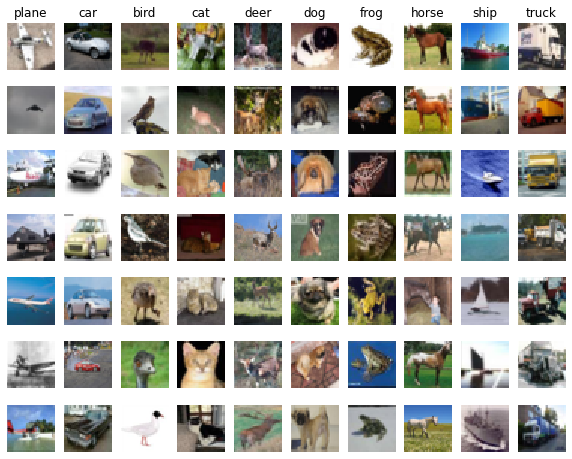

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [8]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


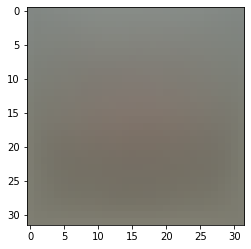

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [9]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

# Programming assignments start here (100 points in total including the other Jupyter notebook file).

## Part 1: Cross-entropy Loss (8 points)

<font size="4" color="red">**Task 1.1: implement the cross-entropy loss for classification (6 points)**</font>
<br><font size="4">(Note no foor loops are allowed.)

In [14]:
def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    
    Hint: You can start with a naive implementation with for loops and vecterize it.
    But no for loops are allowed to use in your final implementation.
    """
    
    # Initialize the loss and gradient to zero.
    dW = np.zeros_like(W)
    
    # Full process...
    NxC = X @ W    # Matrix of subsample vs scores
    
    prob = np.exp(NxC)    # e^ of subsample vs scores
    prob_row_sum = np.sum(prob, axis=1)    # sum of each e^ row for each subsample
    
    x_inc = np.arange(X.shape[0])    # initialize x-increments
    numerator = prob[x_inc, y]    # numerator array for syi
    
    Li = -np.log(numerator/prob_row_sum)    # Loss array for each subsample
    non_reg_loss = np.sum(Li)/Li.shape[0]    # total loss = (1/N)*(sum of Li)
    reg_component = reg*(np.sum(W**2))    # regularized component of loss
    loss = non_reg_loss + reg_component    # together for total loss
        
    prob_div_sum = prob/prob_row_sum.reshape(X.shape[0], 1)    # matrix of e^ scores divided by 
    prob_div_sum[x_inc,y] -= 1    # subtract loss value for correct score
    
    dW = (X.T @ prob_div_sum)/X.shape[0] + reg*W    # calculate dW, divide by N, add regularization

    return loss, dW

In [15]:
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))
assert np.abs(loss + np.log(0.1)) < 0.1

loss: 2.318275
sanity check: 2.302585


# <font size='4' color="red"> **Inline Question 1.2:**
<font size='4'>**Why do we expect our loss to be close to -log(0.1)? Explain briefly. (2 points)**</font>

**Fill in your answer below**
    
We can visualize why our loss is expected to be roughly –log(0.1) by analyzing
certain features of cross entropy loss in relation to our parameters. The log of
the correct score probability should be roughly equal to 1 for cross entropy loss.
Since we are dealing with 10 classes in our example, the sum of each row should
be roughly 10. That means each correct score, divided by the sum of each row,
should be roughly 1/10, or 0.1. Our final loss calculation is essentially the
average of all of these values near 0.1 so should results in roughly –log(0.1).

In [16]:
# Let's check your implementation
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from utils.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.355501 analytic: 0.355501, relative error: 6.168140e-08
numerical: -0.042487 analytic: -0.042487, relative error: 1.025753e-07
numerical: -1.281938 analytic: -1.281938, relative error: 2.889337e-08
numerical: 0.671474 analytic: 0.671474, relative error: 8.393351e-08
numerical: 1.695847 analytic: 1.695847, relative error: 1.616918e-08
numerical: -0.420681 analytic: -0.420681, relative error: 9.749482e-10
numerical: 0.575059 analytic: 0.575058, relative error: 8.881260e-08
numerical: 1.979410 analytic: 1.979410, relative error: 4.055115e-09
numerical: -0.765394 analytic: -0.765394, relative error: 3.979985e-08
numerical: -1.058418 analytic: -1.058418, relative error: 2.118347e-08
numerical: 2.059201 analytic: 2.057736, relative error: 3.559574e-04
numerical: 1.877869 analytic: 1.865514, relative error: 3.300368e-03
numerical: -0.251970 analytic: -0.250414, relative error: 3.098893e-03
numerical: 0.029075 analytic: 0.032604, relative error: 5.722053e-02
numerical: 0.162080 an

In [17]:
# Now that we have an implementation of the softmax loss function and its gradient,
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

vectorized loss: 2.318275e+00 computed in 0.005361s


## Part2: SVM (hinge) loss (8 points)

<font size="4" color="red">**Task 2.1: implement the SVM loss for classification (6 points)**</font>
<br><font size="4">(Note no foor loops are allowed.)

In [18]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Multiclass SVM loss function, vectorized implementation. Set the margin to 1.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W

    Hint 1: You can start with a naive implementation with for loops and vecterize it.
    But no for loops are allowed to use in your final implementation.
    
    Hint 2: Instead of computing the gradient from scratch, it may be easier
    to reuse some of the intermediate values that you used to compute the
    loss.    
    """
    
    dW = np.zeros(W.shape) # initialize the gradient as zero
    
    # Full process...
    scores = X @ W    # NxC matrix of subsample scores
    scores_reshape = scores.reshape(X.shape[0], 1, W.shape[1])    # reshape scores to (N, 1, C) for subtraction
    
    x_inc = np.arange(X.shape[0])    # initialize x increments
    
    syi = scores[x_inc, y]    # scores of syi to subtract
    syi_reshape = syi.reshape(X.shape[0], 1, 1)    # reshape syi in to (N,1,1) for subtraction
    
    margin = scores_reshape - syi_reshape + 1    # array of margin vals (sj-syi+1)
    margin = margin.reshape(X.shape[0], W.shape[1])    # reshape back in to (N,C)
    margin[x_inc, y] = 0    # setting val where sj = syi to 0 instead of 1
    
    margin[margin < 0] = 0    # essentially max(0,sj-syi+1) function
    
    Li = np.sum(margin, axis=1)    # sum max function for total Li
    
    loss = np.sum(Li)/Li.shape[0] + (reg*np.sum(W**2))    # summing total loss across data set, divide by N, add reg

    margin_val_dW = margin    # using (sj-syi+1) values for dW calc
    margin_val_dW[margin > 0] = 1    # obtain matrix of 0's and 1's
    margin_val_dW_rowsum = np.sum(margin_val_dW, axis=1)    #s um of rows of 0's and 1's for sj = syi
    margin_val_dW[x_inc, y] = -margin_val_dW_rowsum.T    # assign counts for when sj = syi
    
    dW = X.T @ margin_val_dW    # calculate dW
    dW = dW/X.shape[0] + reg*W    # (1/N)*dW + reg_dW

    return loss, dW

In [19]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.043345


In [20]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from utils.gradient_check import grad_check_sparse
f = lambda w: svm_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_vectorized(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 2.997051 analytic: 2.997051, relative error: 7.350463e-12
numerical: -16.890517 analytic: -16.890517, relative error: 9.456786e-13
numerical: -37.501918 analytic: -37.501918, relative error: 6.517712e-14
numerical: 14.326046 analytic: 14.326046, relative error: 1.937359e-12
numerical: -1.395084 analytic: -1.395084, relative error: 2.265594e-12
numerical: 19.703067 analytic: 19.703067, relative error: 1.297440e-12
numerical: -11.128662 analytic: -11.128662, relative error: 1.653424e-12
numerical: -3.913340 analytic: -3.913340, relative error: 6.266980e-13
numerical: 26.716365 analytic: 26.716365, relative error: 2.237969e-12
numerical: -14.878844 analytic: -14.878844, relative error: 1.907941e-12
numerical: 34.120881 analytic: 34.114190, relative error: 9.806893e-05
numerical: -6.684615 analytic: -6.682891, relative error: 1.289310e-04
numerical: 16.045962 analytic: 16.046675, relative error: 2.224618e-05
numerical: 0.017920 analytic: 0.013028, relative error: 1.580878e-01
nu

<font size='4' color='red'>**Inline Question 2.2 (2 points):**
    
<font size='4' color='red'>**It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening?**
    
<font size='4' color='red'>**Hint: the SVM loss function is not strictly speaking differentiable.**

**Fill in your answer below**
    
Yes, it is possible that occasionally a dimension in the gradcheck will not match
exactly. This can be caused when, for example, sj – syi +1 = 0, so max(0,0) = 0. It
is a slight reason for concern since it will lead to incorrect results, however it is
very unlikely to happen. To change the frequency of this happening we can add
a regularization to the loss.

## Part3: Linear Classifier (5 points)

<font size='4' color='red'>**Task 3.1: implement a linear classifier (5 points)**

In [27]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None
            
            # Minibatch
            indexes = np.random.choice(num_train, batch_size, replace=False)
            
            X_batch = X[indexes, :]
            y_batch = y[indexes,]

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            self.W += -learning_rate*grad

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        scores_NxC = X @ self.W
        y_pred = np.argmax(scores_NxC, axis=1)

        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        raise NotImplementedError

In [28]:
# we now instantiate two classifiers, Softmax and SVM
class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

## Part4: Model training and hyperparameter tuning (14 points)

### Linear SVM classifier training

iteration 0 / 1500: loss 791.545007
iteration 100 / 1500: loss 474.253844
iteration 200 / 1500: loss 287.079891
iteration 300 / 1500: loss 174.952447
iteration 400 / 1500: loss 107.631686
iteration 500 / 1500: loss 67.288532
iteration 600 / 1500: loss 41.816477
iteration 700 / 1500: loss 27.729016
iteration 800 / 1500: loss 18.548382
iteration 900 / 1500: loss 13.308095
iteration 1000 / 1500: loss 10.582932
iteration 1100 / 1500: loss 8.202747
iteration 1200 / 1500: loss 7.015032
iteration 1300 / 1500: loss 6.757584
iteration 1400 / 1500: loss 6.180634
That took 4.186796s


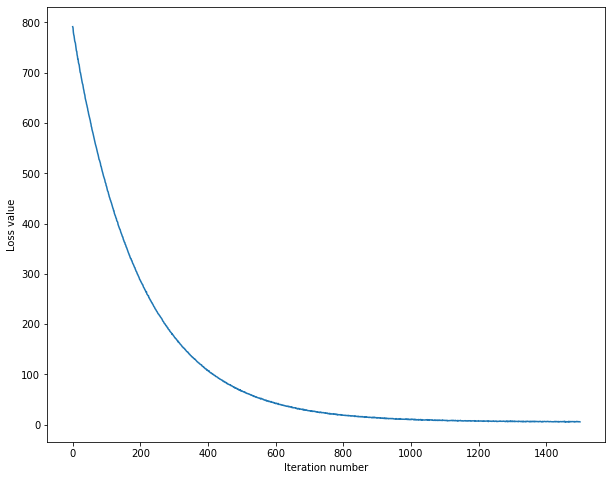

training accuracy: 0.376571
validation accuracy: 0.384000


In [29]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

# A useful debugging strategy is to plot the loss as a function of
# iteration number:
# you should see a nicely decreasing loss curve
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

<font size='4' color='red'>**Task 4.1: tune the hyperparameters for the SVM classifier to get a classification accuracy over 0.4 on the validation set (5 points)**

In [30]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-8, 5e-7]
regularization_strengths = [1e4,1e5]

# 0.39 ish
# learning_rates = [1e-8, 5e-7]
# regularization_strengths = [1e4,1e5] num_iters = 2000

# print('learning_rates shape: {}\n'.format(learning_rates))
# print('regularization_strengths shape: {}\n'.format(regularization_strengths))

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# reg and learning rate

num_iterations = 10
best_learning_rate = 0
best_reg_strength = 0

for i in range(num_iterations):
    learning_rate = learning_rates[0] + i*learning_rates[len(learning_rates)-1]/num_iterations
    reg = regularization_strengths[0] + i*regularization_strengths[len(regularization_strengths)-1]/num_iterations
    classifier = LinearSVM()
    
    classifier.train(X_train, y_train, learning_rate=learning_rate, reg=reg, num_iters=2000, verbose=False)
    
    validation_set_y = classifier.predict(X_val)
    training_set_y = classifier.predict(X_train)
    
    val_equals_count = np.sum(y_val == validation_set_y)
    train_equals_count = np.sum(y_train == training_set_y)
    
    valid_accuracy = val_equals_count/(y_val.size)
    train_accuracy = train_equals_count/(y_train.size)
    
    results[learning_rate, reg] = train_accuracy, valid_accuracy
    
    if valid_accuracy > best_val:
        best_svm = classifier
        best_val = valid_accuracy
        best_learning_rate = learning_rate
        best_reg_strength = reg

print('Best learning rate in range: {}'.format(best_learning_rate))
print('Best reg strength in range: {}\n'.format(best_reg_strength))

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Best learning rate in range: 1.0999999999999999e-07
Best reg strength in range: 30000.0

lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.237878 val accuracy: 0.233000
lr 6.000000e-08 reg 2.000000e+04 train accuracy: 0.384265 val accuracy: 0.381000
lr 1.100000e-07 reg 3.000000e+04 train accuracy: 0.377306 val accuracy: 0.386000
lr 1.600000e-07 reg 4.000000e+04 train accuracy: 0.371265 val accuracy: 0.384000
lr 2.100000e-07 reg 5.000000e+04 train accuracy: 0.352816 val accuracy: 0.359000
lr 2.600000e-07 reg 6.000000e+04 train accuracy: 0.357245 val accuracy: 0.357000
lr 3.100000e-07 reg 7.000000e+04 train accuracy: 0.343082 val accuracy: 0.350000
lr 3.600000e-07 reg 8.000000e+04 train accuracy: 0.341449 val accuracy: 0.368000
lr 4.100000e-07 reg 9.000000e+04 train accuracy: 0.336102 val accuracy: 0.326000
lr 4.600000e-07 reg 1.000000e+05 train accuracy: 0.327653 val accuracy: 0.346000
best validation accuracy achieved during cross-validation: 0.386000


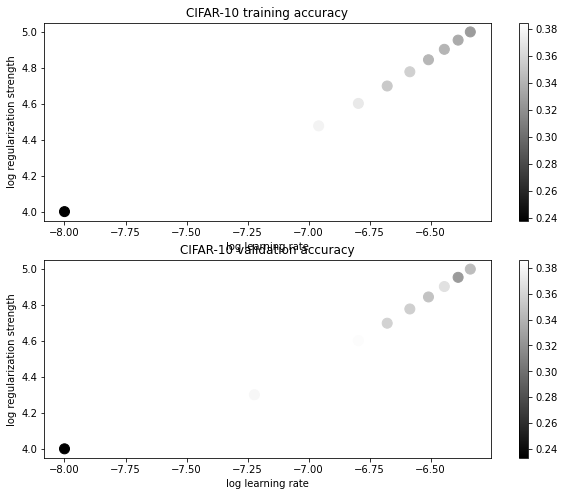

In [31]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [32]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.365000


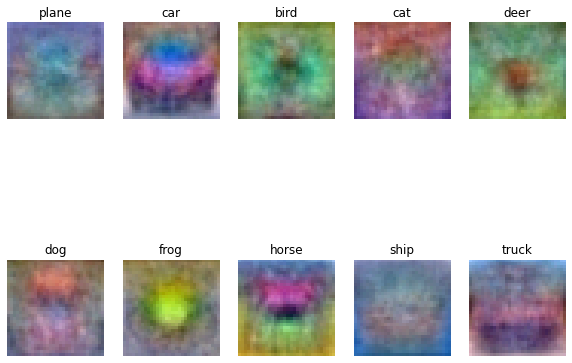

In [33]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

<font size='4' color='red'>**Inline question 4.1:**
<font size='4' color='red'>**Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do. (2 points)**

**Fill in your answer below**
    
The visualized weights look like a blurry low-res version of each picture, similar
to if some sort of gaussian filter was applied to the image. They look like this
because the weights applied to the images act as filters that best identify the
descriptive features of the images.

### Softmax classifier training

<font size='4' color='red'>**Task 4.2: Tune the hyperparameters for the Softmax classifier to get a classification accuracy of over 0.35 on the validation set. (5 points)**

In [34]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

num_iterations = 5
best_learning_rate = 0
best_reg_strength = 0

for i in range(num_iterations):
    learning_rate = learning_rates[0]+i*learning_rates[len(learning_rates)-1]/num_iterations
    reg = regularization_strengths[0]+i*regularization_strengths[len(regularization_strengths)-1]/num_iterations
    classifier = Softmax()
    
    classifier.train(X_train, y_train, learning_rate=learning_rate,
        reg=reg, num_iters=500, verbose=False)
    
    validation_set_y = classifier.predict(X_val)
    training_set_y = classifier.predict(X_train)
    
    val_equals_count = np.sum(y_val == validation_set_y)
    train_equals_count = np.sum(y_train == training_set_y)
    
    valid_accuracy = val_equals_count/(y_val.size)
    train_accuracy = train_equals_count/(y_train.size)
    
    results[learning_rate, reg] = (train_accuracy, valid_accuracy)
    
    if valid_accuracy > best_val:
        best_softmax = classifier
        best_val = valid_accuracy
        best_learning_rate = learning_rate
        best_reg_strength = reg

print('Best learning rate in range: {}'.format(best_learning_rate))
print('Best reg strength in range: {}\n'.format(best_reg_strength))

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Best learning rate in range: 3e-07
Best reg strength in range: 45000.0

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.264163 val accuracy: 0.260000
lr 2.000000e-07 reg 3.500000e+04 train accuracy: 0.332102 val accuracy: 0.332000
lr 3.000000e-07 reg 4.500000e+04 train accuracy: 0.334306 val accuracy: 0.341000
lr 4.000000e-07 reg 5.500000e+04 train accuracy: 0.328347 val accuracy: 0.328000
lr 5.000000e-07 reg 6.500000e+04 train accuracy: 0.312490 val accuracy: 0.324000
best validation accuracy achieved during cross-validation: 0.341000


In [35]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.345000


<font size='4' color='red'>**Inline Question 4.2** - *True or False*

<font size='4' color='red'>**It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss. (2 points)**

*Your answer*: True

*Your explanation*: Adding a new data point can result in the the SVM loss to remain the same
while changing the softmax loss. This can happen is the calculation of sj – syi +1
is less than 0, and therefore the max function max(sj - syi +1, 0) = 0. This will not
change the outcome of the loss calculation, however in the softmax classifier will
slightly change the denominator value of the row, slightly changing the loss
calculation.

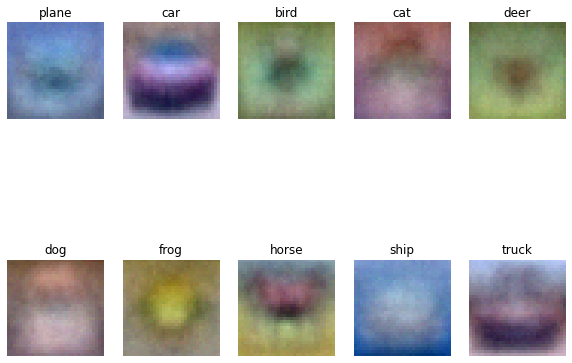

In [36]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])